In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
 !pip install tensorflow-addons

In [26]:


%matplotlib inline
import IPython.core.display         
# setup output image format (Chrome works best)
IPython.core.display.set_matplotlib_formats("svg")
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import PIL
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm
import tensorflow_addons as tfa
import random
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Conv2D, Flatten, Dropout, Input, BatchNormalization, \
                                    GlobalAveragePooling2D, Concatenate
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import logging
logging.basicConfig()
import struct
print(keras.__version__, tf.__version__)
# use keras backend (K) to force channels-last ordering
K.set_image_data_format('channels_last')
pd.set_option("display.max_columns", None)



2.4.0 2.4.1


18632
Index(['image', 'labels'], dtype='object')
AxesSubplot(0.125,0.125;0.775x0.755)


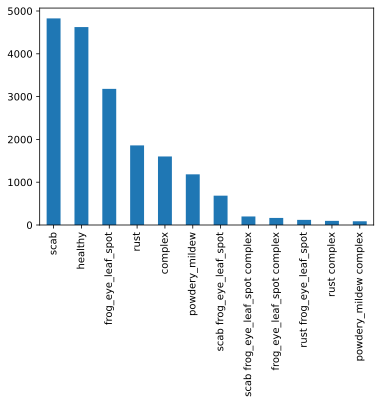

In [27]:
train = pd.read_csv(r'C:\Users\aruve\Downloads\plant-pathology-2021-fgvc8\train.csv')
print(len(train))
print(train.columns)
# print(train['labels'].value_counts())
print(train['labels'].value_counts().plot.bar())

In [28]:

train['labels'] = train['labels'].apply(lambda string: string.split(' '))




Index(['complex', 'frog_eye_leaf_spot', 'healthy', 'powdery_mildew', 'rust',
       'scab'],
      dtype='object')
complex               2151
frog_eye_leaf_spot    4352
healthy               4624
powdery_mildew        1271
rust                  2077
scab                  5712
dtype: int64
['complex', 'frog_eye_leaf_spot', 'healthy', 'powdery_mildew', 'rust', 'scab']


<AxesSubplot:>

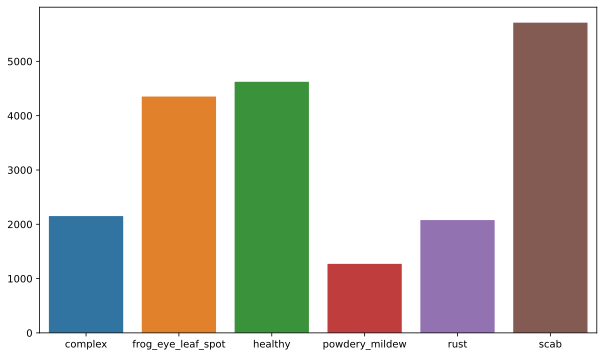

In [29]:
s = list(train['labels'])
mlb = MultiLabelBinarizer()
trainx = pd.DataFrame(mlb.fit_transform(s), columns=mlb.classes_, index=train.index)
print(trainx.columns)
print(trainx.sum())

labels = list(trainx.sum().keys())
print(labels)
label_counts = trainx.sum().values.tolist()

fig, ax = plt.subplots(1,1, figsize=(10,6))

sns.barplot(x= labels, y= label_counts, ax=ax)

In [31]:
try: # detect TPUs
  tpu = None
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError: # detect GPUs
  strategy = tf.distribute.MirroredStrategy() # for GPU or multi-GPU machines
  #strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  #strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy() # for clusters of multi-GPU machines

print("Number of accelerators: ", strategy.num_replicas_in_sync)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


Number of accelerators:  1


In [34]:
train_dir = r'C:\Users\aruve\Downloads\plant-pathology-2021-fgvc8\train_images'

def add_gauss_noise(X, sigma2=0.1):  #0.05
    # add Gaussian noise with zero mean, and variance sigma2
    return X + np.random.normal(0, sigma2, X.shape)

# build the data augmenter
datagen = ImageDataGenerator(
    rescale=1/255.0,
    rotation_range=10,         # image rotation
    width_shift_range=0.1,     # image shifting
    height_shift_range=0.1,    # image shifting
    shear_range=0.1,           # shear transformation
    zoom_range=0.1,            # zooming
    horizontal_flip=True, 
    preprocessing_function=add_gauss_noise, 
    validation_split=0.1
)
batch_size = 16

train_generator = datagen.flow_from_dataframe(
    train,
    directory=train_dir,
    x_col="image",
    y_col= 'labels',
    subset="training",
    color_mode="rgb",
    target_size = (224,224),
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=False,
    seed=40,
)
validation_generator = datagen.flow_from_dataframe(
    train,
    directory=train_dir,
    x_col="image",
    y_col= 'labels',
    subset="validation",
    color_mode="rgb",
    target_size = (224,224),
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=False,
    seed=40,
)

Found 16769 validated image filenames belonging to 6 classes.
Found 1863 validated image filenames belonging to 6 classes.


In [35]:
accname = 'f1_score'

def plot_history(history): 
    fig, ax1 = plt.subplots()
    
    ax1.plot(history.history['loss'], 'r', label="training loss ({:.6f})".format(history.history['loss'][-1]))
    ax1.plot(history.history['val_loss'], 'r--', label="validation loss ({:.6f})".format(history.history['val_loss'][-1]))
    ax1.grid(True)
    ax1.set_xlabel('iteration')
    ax1.legend(loc="best", fontsize=9)    
    ax1.set_ylabel('loss', color='r')
    ax1.tick_params('y', colors='r')

    if accname in history.history:
        ax2 = ax1.twinx()

        ax2.plot(history.history[accname], 'b', label="training f1_score ({:.4f})".format(history.history[accname][-1]))
        ax2.plot(history.history['val_'+accname], 'b--', label="validation f1_score ({:.4f})".format(history.history['val_'+accname][-1]))

        ax2.legend(loc="lower right", fontsize=9)
        ax2.set_ylabel('acc', color='b')  

In [36]:
# import tensorflow.keras.applications.resnet50 as resnet
from tensorflow.keras.preprocessing import image

K.clear_session()
random.seed(4487); tf.random.set_seed(4487)

# create the base pre-trained model with-out the classifier
# using global average pooling
weight_path = r'C:\Users\aruve\Downloads\plant-pathology-2021-fgvc8\xception_weights_tf_dim_ordering_tf_kernels_notop.h5'
base_model = tf.keras.applications.Xception(weights=weight_path, include_top=False, pooling='avg')

# start with the output of the ResNet50 (1x1x2048) 
x = base_model.output

# # fully-connected layer 
# x = Dense(128, activation='relu')(x)
# # fully-connected layer 
# x = Dense(64, activation='relu')(x)
# # fully-connected layer 
x = Dense(16, activation='relu')(x)
# finally, the softmax for the classifier 
predictions = Dense(6, activation='sigmoid')(x)

C:\Users\aruve\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
1049/1049 [==============================] - 2404s 2s/step - loss: 0.3292 - f1_score: 0.4646 - val_loss: 0.1202 - val_f1_score: 0.8620
Epoch 2/10
1049/1049 [==============================] - 1861s 2s/step - loss: 0.1255 - f1_score: 0.8409 - val_loss: 0.1051 - val_f1_score: 0.8746
Epoch 3/10
1049/1049 [==============================] - 2339s 2s/step - loss: 0.0948 - f1_score: 0.8748 - val_loss: 0.1038 - val_f1_score: 0.8557
Epoch 4/10
1049/1049 [==============================] - 1952s 2s/step - loss: 0.0735 - f1_score: 0.8943 - val_loss: 0.1080 - val_f1_score: 0.8599
Epoch 5/10
1049/1049 [==============================] - 1929s 2s/step - loss: 0.0634 - f1_score: 0.9061 - val_loss: 0.0985 - val_f1_score: 0.8866
Epoch 6/10
1049/1049 [==============================] - 2525s 2s/step - loss: 0.0524 - f1_score: 0.9227 - val_loss: 0.1062 - val_f1_score: 0.8839
Epoch 7/10
1049/1049 [==============================] - 1923s 2s/step - loss: 0.0410 - f1_score: 0.9339 - val_loss: 0.1077 -

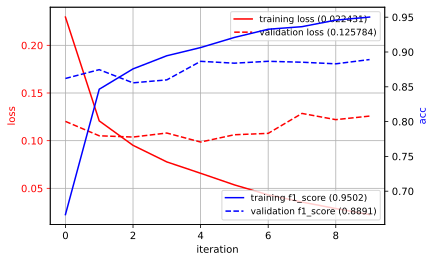

In [8]:

model_ft = Model(inputs=base_model.input, outputs=predictions)

f1 = tfa.metrics.F1Score(num_classes=6, average='macro')

model_ft.compile(optimizer=keras.optimizers.SGD(lr=0.03, 
                                decay=1e-4,  
                                momentum=0.8, nesterov=True), 
              loss='binary_crossentropy', metrics=[f1])


accearlystop = keras.callbacks.EarlyStopping(
    monitor=f1,     
    min_delta=0.02,      
    patience=5,             
    verbose=1, mode='max', restore_best_weights= True
)
lossearlystop = keras.callbacks.EarlyStopping(
    monitor='val_loss',     
    min_delta=0.02,       
    patience=5,             
    verbose=1, mode='min', restore_best_weights= True
)

lrschedule = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                 factor=0.05, patience=5, verbose=1)

callbacks_list = []



STEP_SIZE_TRAIN=train_data.n
STEP_SIZE_VALID=valid_data.n
history = model_ft.fit_generator(
            train_data,  # data from generator

            epochs=10,
            callbacks=callbacks_list, 
            validation_data=valid_data, 
#             validation_steps = 1,
            verbose=True)

plot_history(history)

In [13]:
import pickle

# save:
f = open('history.pckl', 'wb')
pickle.dump(history.history, f)
f.close()

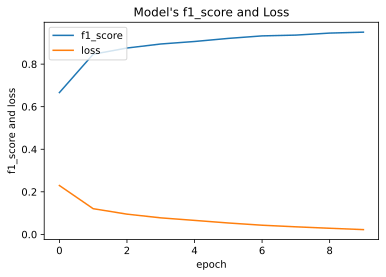

In [25]:

from matplotlib import pyplot as plt
plt.plot(history.history['f1_score'])
plt.plot(history.history['loss'])
plt.title("Model's f1_score and Loss")
plt.ylabel('f1_score and loss')
plt.xlabel('epoch')
plt.legend(['f1_score', 'loss'], loc='upper left')
plt.show()